<a href="https://colab.research.google.com/github/aditya-dl/Deploying-Deep-Learning-Manning/blob/main/Build_a_food_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the Food-101 dataset

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2020-11-28 08:46:50--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2020-11-28 08:46:51--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  18.7MB/s    in 4m 11s  

2020-11-28 08:51:02 (19.0 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
!tar -zxf food-101.tar.gz

**Re-arranging dataset into folders**

In [4]:
from collections import defaultdict
from shutil import copy
import os
import gc

# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [5]:
# create training data
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images/', '/content/data/train')
print("Created training data.")

Copying Done!
Created training data.


In [6]:
print("Total number of samples in train folder")
!find /content/data/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [7]:
# create testing data
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images/', '/content/data/test')
print("Created testing data.")

Copying Done!
Created testing data.


In [8]:
print("Total number of samples in test folder")
!find /content/data/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [11]:
!tar -zcf data.tar.gz data

### Image Data Generator

In [33]:
# import dependencies
from keras.preprocessing.image import ImageDataGenerator

In [19]:
import cv2
img = cv2.imread("/content/data/train/baklava/1021344.jpg")
img.shape

(512, 512, 3)

In [34]:
train_dir = "/content/data/train/"
test_dir = "/content/data/test/"

In [35]:
# train data generator
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.2, 
    zoom_range=0.2,
    channel_shift_range=0.,
    horizontal_flip = True,
    fill_mode='nearest'
)

# test data generator
test_datagen = ImageDataGenerator(
    rescale=1/255)

# Create a flow
train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beignets'], 
    target_size=(224, 224),
    batch_size=64,  
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beignets'],
    target_size=(224, 224),
    batch_size=64
)

Found 3750 images belonging to 5 classes.
Found 1250 images belonging to 5 classes.


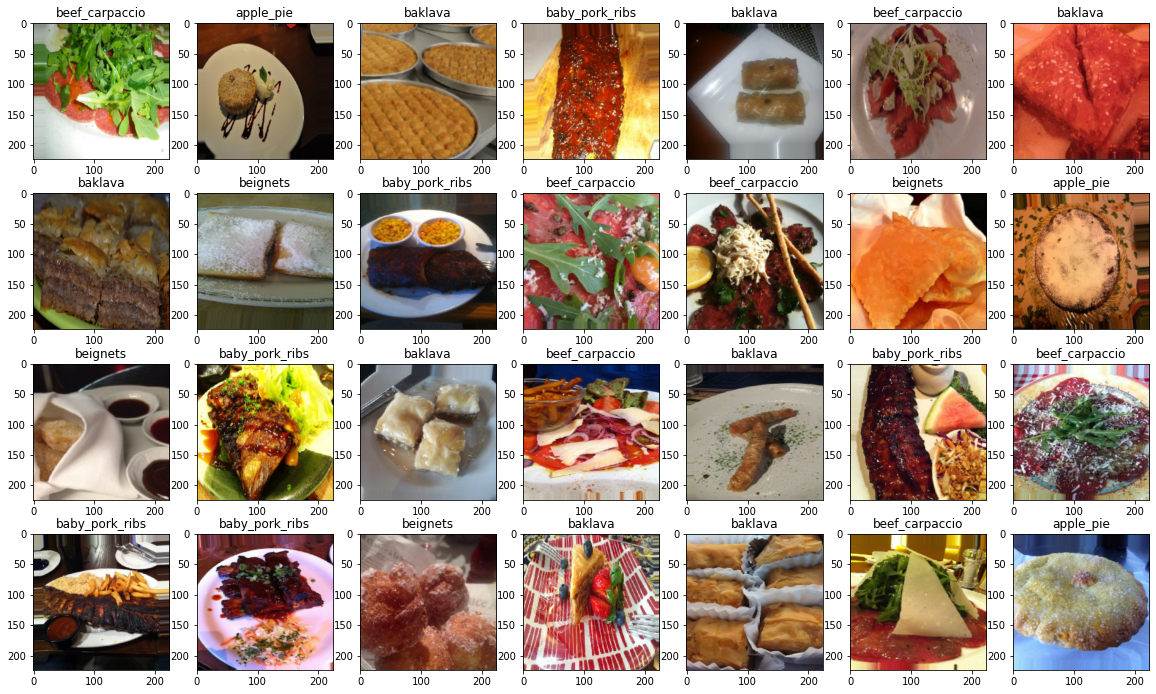

In [36]:
# Preview images from train generator
# preview images from train generator
import matplotlib.pyplot as plt
import numpy as np
r = 4; c = 7
n=0
classtolabel = {'0':'apple_pie','1':'baby_pork_ribs','2':'baklava', '3':'beef_carpaccio', '4':'beignets'}
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

# Train VGG19 model using Transfer Learning

In [3]:
# import dependencies
from keras.applications import VGG19
from keras.models import Sequential
from keras import layers, optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.regularizers import l2

In [6]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [8]:
# set trainable to false 
conv_base.trainable = False

# Create model
model = Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2()))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 2565      
Total params: 21,077,061
Trainable params: 1,052,677
Non-trainable params: 20,024,384
__________________________________

In [10]:
# compile model with appropriate loss and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
#callbacks
checkpointer = ModelCheckpoint(filepath='model.h5', verbose=1, save_best_only=True, save_weights_only=False)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')

history = model.fit(train_generator,
                    steps_per_epoch=3750/64,
                    epochs=100,
                    validation_data=test_generator,
                    validation_steps=1250/64,
                    callbacks=[checkpointer, reduceLR, earlystopping],
                    use_multiprocessing=True)

# Train RESNET50 using Transfer **Learning**

In [37]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras import layers, optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.regularizers import l2

In [38]:
conv_base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# set trainable to false 
conv_base_resnet.trainable = False

# Create model
model_resnet = Sequential()
model_resnet.add(conv_base_resnet)
model_resnet.add(layers.GlobalAveragePooling2D())
model_resnet.add(layers.Dense(1024, activation='relu', kernel_initializer='he_normal'))
model_resnet.add(layers.Dropout(0.2))
model_resnet.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
model_resnet.add(layers.Dropout(0.2))
model_resnet.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
model_resnet.add(layers.Dense(5, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2()))

In [39]:
model_resnet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [40]:
# compile model with appropriate loss and optimizer
model_resnet.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
#callbacks
checkpointer = ModelCheckpoint(filepath='model_resnet.h5', verbose=1, save_best_only=True, save_weights_only=False)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')

history_resnet = model_resnet.fit(train_generator,
                    steps_per_epoch=3750/64,
                    epochs=100,
                    validation_data=test_generator,
                    validation_steps=1250/64,
                    callbacks=[checkpointer, reduceLR, earlystopping],
                    use_multiprocessing=True)

# Train MobileNetV2 

In [10]:
# import dependencies
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras import layers, optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.regularizers import l2

In [21]:
conv_base_mob = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# set trainable to false 
conv_base_mob.trainable = False

# Create model
model_mob = Sequential()
model_mob.add(conv_base_mob)
model_mob.add(layers.GlobalAveragePooling2D())
model_mob.add(layers.Dense(1024, activation='relu', kernel_initializer='he_normal'))
model_mob.add(layers.Dropout(0.2))
model_mob.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
# model.add(layers.Dropout(0.2))
model_mob.add(layers.Dense(5, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2()))

In [23]:
model_mob.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 4,097,093
Trainable params: 1,839,109
Non-trainable params: 2,257,984
____________________________________

In [24]:
# compile model with appropriate loss and optimizer
model_mob.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [26]:
#callbacks
checkpointer = ModelCheckpoint(filepath='model_mob.h5', verbose=1, save_best_only=True, save_weights_only=False)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')

history = model_mob.fit(train_generator,
                    steps_per_epoch=3750/64,
                    epochs=100,
                    validation_data=test_generator,
                    validation_steps=1250/64,
                    callbacks=[checkpointer, reduceLR, earlystopping],
                    use_multiprocessing=True)

Epoch 1/100
59/58 [==============================] - ETA: 0s - loss: 0.8720 - accuracy: 0.7216WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_loss improved from inf to 0.49772, saving model to model_mob.h5
59/58 [==============================] - 71s 1s/step - loss: 0.8720 - accuracy: 0.7216 - val_loss: 0.4977 - val_accuracy: 0.8464
Epoch 2/100
59/58 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.8435WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_loss improved from 0.49772 to 0.43734, saving model to model_mob.h5
59/58 [==============================] - 67s 1s/step - loss: 0.4994 - accuracy: 0.8435 - val_loss: 0.4373 - val_accuracy: 0.8728
Epoch 3/100
59/58 [==============================] -

# Results table


**Model** | **Trainable Params** | **Non-trainable Params** | **Time (hh:mm:ss)** | **Accuracy** | **Epochs** | **Model Size**
--- | --- | --- | --- | --- | --- | --- 
VGG19 | 1,052,677 | 20,024,384 | 00:40:56 |  78% | 50 | 86.4MB
ResNet50 | 2,755,589 | 23,587,712 | 01:50:20 | 88% | 99 | 121.85MB
MobileNetV2 | 1,839,109 | 2,257,984 | 00:19:20 | 98% | 17 | 29.96MB